In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

In [3]:
df = pd.read_csv("cctv_frames.csv")

In [4]:
print("Shape:", df.shape)
print(df.head())
print(df.info())

Shape: (7000, 4)
   frame_id  location_id        timestamp  face_id
0  FR600000      LAB_101   9/1/2025 12:29      NaN
1  FR600001      LIB_ENT   9/4/2025 10:27      NaN
2  FR600002  ADMIN_LOBBY    9/6/2025 5:36  F102064
3  FR600003   AUDITORIUM   9/16/2025 3:05  F100578
4  FR600004  ADMIN_LOBBY  8/30/2025 22:18      NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   frame_id     7000 non-null   object
 1   location_id  7000 non-null   object
 2   timestamp    7000 non-null   object
 3   face_id      4213 non-null   object
dtypes: object(4)
memory usage: 218.9+ KB
None


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [29]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()
df['date'] = df['timestamp'].dt.date

In [30]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
frame_id               0
location_id            0
timestamp              0
face_id             2787
date                   0
hour                   0
day                    0
month                  0
weekday                0
location_encoded       0
face_encoded           0
dtype: int64


In [31]:
print("\nUnique Locations:", df['location_id'].nunique())
print("Unique Faces:", df['face_id'].nunique())
print("Unique Frames:", df['frame_id'].nunique())


Unique Locations: 8
Unique Faces: 2821
Unique Frames: 7000


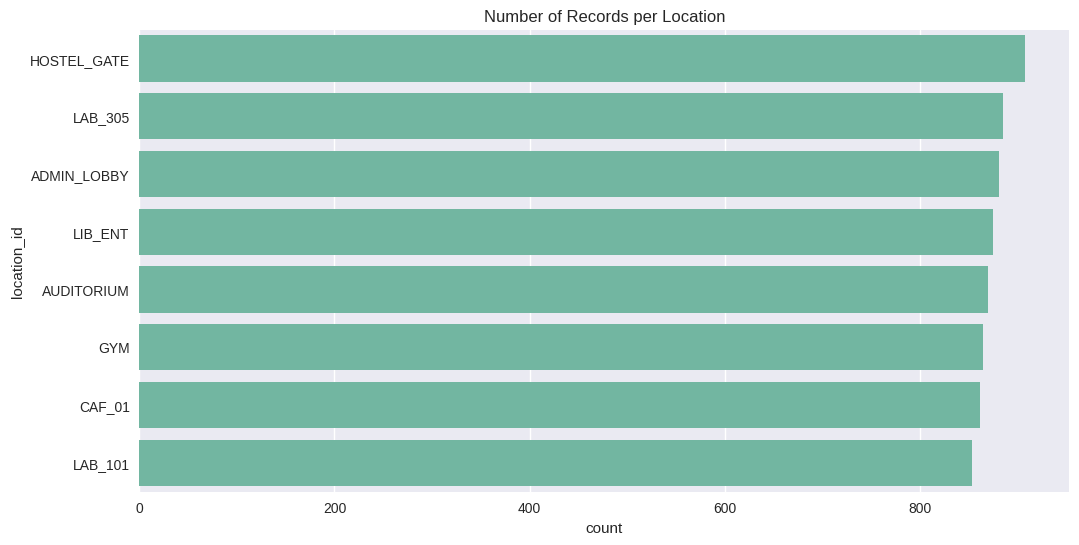

In [32]:
# (a) Records per location
plt.figure(figsize=(12,6))
sns.countplot(y='location_id', data=df, order=df['location_id'].value_counts().index)
plt.title("Number of Records per Location")
plt.show()

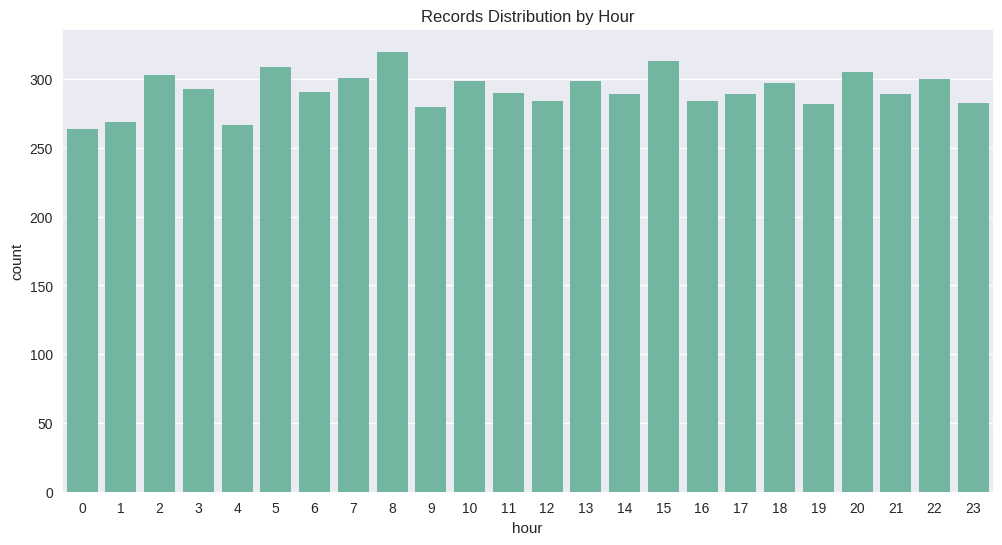

In [33]:
# (b) Hourly distribution
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=df)
plt.title("Records Distribution by Hour")
plt.show()

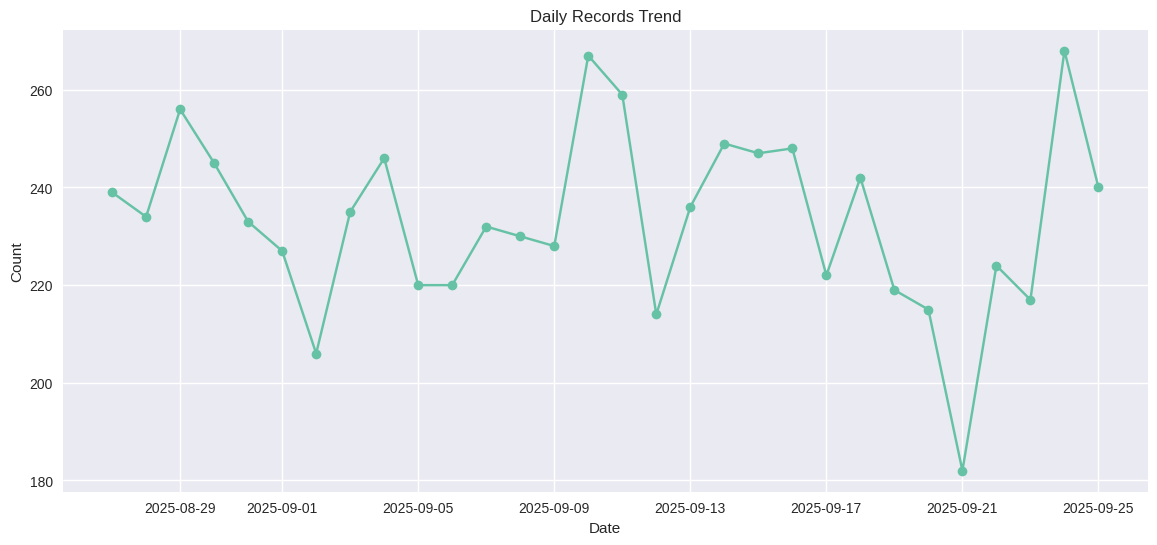

In [34]:
# (c) Daily trend
daily_counts = df.groupby('date').size()
plt.figure(figsize=(14,6))
daily_counts.plot(marker='o')
plt.title("Daily Records Trend")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.show()

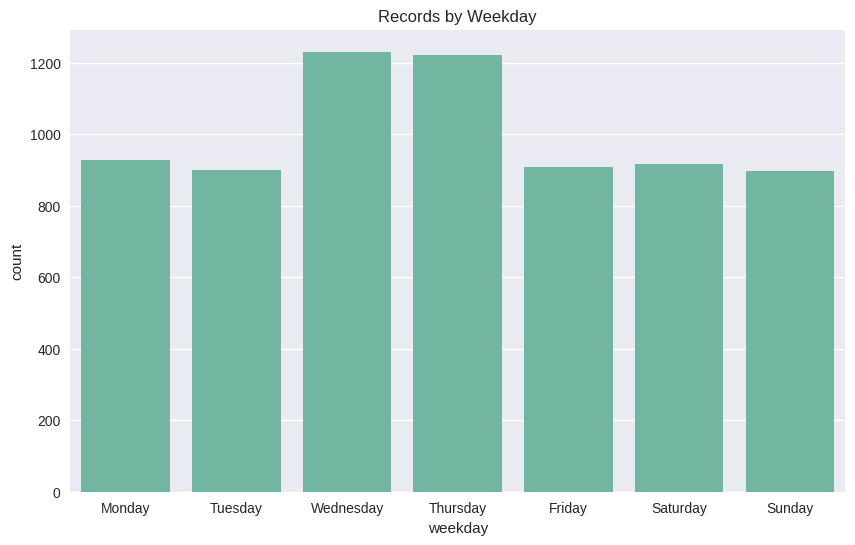

In [35]:
# (d) Weekday activity
plt.figure(figsize=(10,6))
sns.countplot(x='weekday', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Records by Weekday")
plt.show()

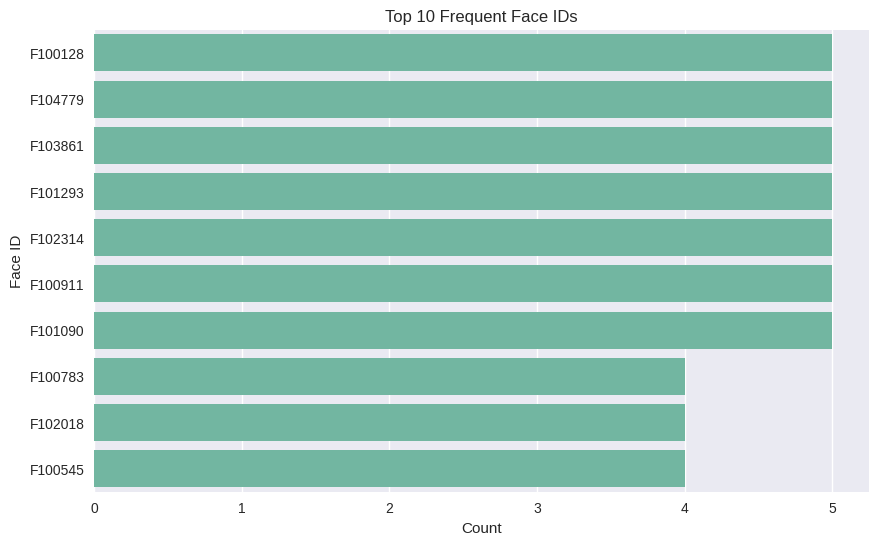

In [36]:
# (e) Top 10 Face IDs
top_faces = df['face_id'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_faces.values, y=top_faces.index)
plt.title("Top 10 Frequent Face IDs")
plt.xlabel("Count")
plt.ylabel("Face ID")
plt.show()

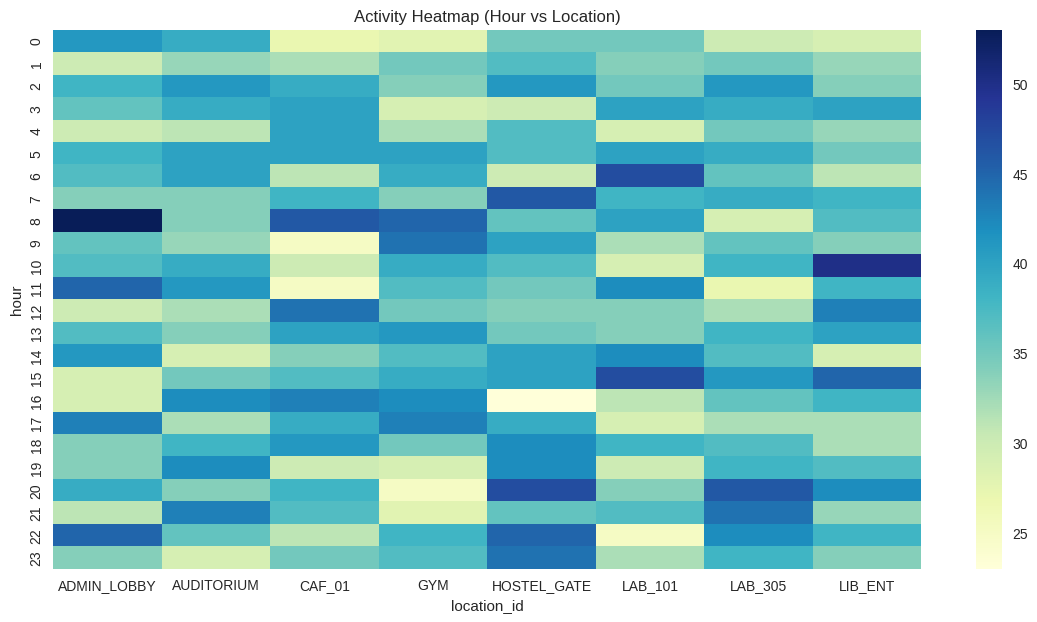

In [37]:
#Extra: Crosstab (Location vs Hour)

heatmap_data = pd.crosstab(df['hour'], df['location_id'])
plt.figure(figsize=(14,7))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title("Activity Heatmap (Hour vs Location)")
plt.show()

# Anomaly Detection

In [38]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN

In [39]:
le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['location_id'])

le_face = LabelEncoder()
df['face_encoded'] = le_face.fit_transform(df['face_id'].astype(str))

In [40]:
#Rule-Based Anomaly Detection

In [42]:

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


duplicates = df[df.duplicated(subset=['frame_id'], keep=False)]


missing_faces = df[df['face_id'].isnull()]


invalid_timestamps = df[df['timestamp'].isnull()]


same_time_conflict = df.groupby(['face_id','timestamp']).filter(lambda x: x['location_id'].nunique() > 1)


df_sorted = df.sort_values(['face_id','timestamp'])
df_sorted['time_diff'] = df_sorted.groupby('face_id')['timestamp'].diff().dt.total_seconds()/60  # in minutes
fast_movement = df_sorted[
    (df_sorted['time_diff'] < 2) &
    (df_sorted['location_id'] != df_sorted.groupby('face_id')['location_id'].shift())
]

# Rare faces (appear only once)
face_counts = df['face_id'].value_counts()
rare_faces = face_counts[face_counts == 1]

# Location spikes (z-score > 3)
location_daily = df.groupby(['location_id', df['timestamp'].dt.date]).size().reset_index(name='count')
stats = location_daily.groupby('location_id')['count'].agg(['mean','std']).reset_index()
location_daily = location_daily.merge(stats, on='location_id')
location_spikes = location_daily[location_daily['count'] > location_daily['mean'] + 3*location_daily['std']]

# Summary
print("\nRule-based anomalies summary:")
print("Duplicate frames:", duplicates.shape[0])
print("Missing faces:", missing_faces.shape[0])
print("Invalid timestamps:", invalid_timestamps.shape[0])
print("Same face in two places same time:", same_time_conflict.shape[0])
print("Fast movements:", fast_movement.shape[0])
print("Rare faces:", rare_faces.shape[0])
print("Location spikes:", location_spikes.shape[0])



Rule-based anomalies summary:
Duplicate frames: 0
Missing faces: 2787
Invalid timestamps: 0
Same face in two places same time: 0
Fast movements: 0
Rare faces: 1777
Location spikes: 0


In [43]:
print("Shape:", df.shape)
print(df.head())
print(df.info())

Shape: (7000, 11)
   frame_id  location_id           timestamp  face_id        date  hour  day  \
0  FR600000      LAB_101 2025-09-01 12:29:00      NaN  2025-09-01    12    1   
1  FR600001      LIB_ENT 2025-09-04 10:27:00      NaN  2025-09-04    10    4   
2  FR600002  ADMIN_LOBBY 2025-09-06 05:36:00  F102064  2025-09-06     5    6   
3  FR600003   AUDITORIUM 2025-09-16 03:05:00  F100578  2025-09-16     3   16   
4  FR600004  ADMIN_LOBBY 2025-08-30 22:18:00      NaN  2025-08-30    22   30   

   month   weekday  location_encoded  face_encoded  
0      9    Monday                 5          2821  
1      9  Thursday                 7          2821  
2      9  Saturday                 0          1164  
3      9   Tuesday                 1           334  
4      8  Saturday                 0          2821  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------           

In [44]:
columns_to_save = ['frame_id', 'location_id', 'timestamp', 'face_id',
                   'date', 'hour', 'day', 'month', 'weekday',
                   'location_encoded', 'face_encoded']


df[columns_to_save].to_csv('cctv_frames_eda.csv', index=False)
print("Saved dataframe with selected columns to 'cctv_frames_eda.csv'")

Saved dataframe with selected columns to 'cctv_frames_eda.csv'
